In [6]:
from torch.utils.data import Dataset
import pandas as pd
# Torch: A library for scientific computing and deep learning
import torch
import numpy as np
# Vedo: A library for 3D data visualization and analysis for vtk files
from vedo import *
from scipy.spatial import distance_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


Definition des classes utiles 

Class Mesh_dataset

In [7]:
from torch.utils.data import Dataset
import pandas as pd
import torch
import numpy as np
from vedo import load
from scipy.spatial import distance_matrix

class Mesh_Dataset(Dataset):
    def __init__(self, data_list_path, num_classes=15, patch_size=7000):
        self.data_list = pd.read_csv(data_list_path, header=None)
        self.num_classes = num_classes
        self.patch_size = patch_size

    def __len__(self):
        return self.data_list.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        i_mesh = self.data_list.iloc[idx][0]  # vtk file name

        # read vtk
        mesh = load(i_mesh)
        labels = mesh.celldata['MaterialIds'].astype('int32').reshape(-1, 1)

        # move mesh to origin
        points = mesh.vertices
        mean_cell_centers = mesh.center_of_mass()
        points[:, 0:3] -= mean_cell_centers[0:3]

        ids = np.array(mesh.cells)
        cells = points[ids].reshape(mesh.ncells, 9).astype(dtype='float32')

        # customized normal calculation; the vtk/vedo build-in function will change number of points
        mesh.compute_normals()
        normals = mesh.celldata['Normals']

        # move mesh to origin
        barycenters = mesh.cell_centers  # don't need to copy
        barycenters -= mean_cell_centers[0:3]

        # normalized data
        maxs = points.max(axis=0)
        mins = points.min(axis=0)
        means = points.mean(axis=0)
        stds = points.std(axis=0)
        nmeans = normals.mean(axis=0)
        nstds = normals.std(axis=0)

        for i in range(3):
            cells[:, i] = (cells[:, i] - means[i]) / stds[i]  # point 1
            cells[:, i+3] = (cells[:, i+3] - means[i]) / stds[i]  # point 2
            cells[:, i+6] = (cells[:, i+6] - means[i]) / stds[i]  # point 3
            barycenters[:, i] = (barycenters[:, i] - mins[i]) / (maxs[i]-mins[i])
            normals[:, i] = (normals[:, i] - nmeans[i]) / nstds[i]

        X = np.column_stack((cells, barycenters, normals))
        Y = labels

        # initialize batch of input and label
        X_train = np.zeros([self.patch_size, X.shape[1]], dtype='float32')
        Y_train = np.zeros([self.patch_size, Y.shape[1]], dtype='int32')
        S1 = np.zeros([self.patch_size, self.patch_size], dtype='float32')
        S2 = np.zeros([self.patch_size, self.patch_size], dtype='float32')

        # calculate number of valid cells (tooth instead of gingiva)
        positive_idx = np.argwhere(labels > 0)[:, 0]  # tooth idx
        negative_idx = np.argwhere(labels == 0)[:, 0]  # gingiva idx

        num_positive = len(positive_idx)  # number of selected tooth cells

        if num_positive > self.patch_size:  # all positive_idx in this patch
            positive_selected_idx = np.random.choice(positive_idx, size=self.patch_size, replace=False)
            selected_idx = positive_selected_idx
        else:  # patch contains all positive_idx and some negative_idx
            num_negative = self.patch_size - num_positive  # number of selected gingiva cells
            positive_selected_idx = np.random.choice(positive_idx, size=num_positive, replace=False)
            negative_selected_idx = np.random.choice(negative_idx, size=num_negative, replace=False)
            selected_idx = np.concatenate((positive_selected_idx, negative_selected_idx))

        selected_idx = np.sort(selected_idx, axis=None)

        X_train[:] = X[selected_idx, :]
        Y_train[:] = Y[selected_idx, :]

        if torch.cuda.is_available():
            TX = torch.as_tensor(X_train[:, 9:12], device='cuda')
            TD = torch.cdist(TX, TX)
            D = TD.cpu().numpy()
        else:
            D = distance_matrix(X_train[:, 9:12], X_train[:, 9:12])

        S1[D < 0.1] = 1.0
        S1 = S1 / np.dot(np.sum(S1, axis=1, keepdims=True), np.ones((1, self.patch_size)))

        S2[D < 0.2] = 1.0
        S2 = S2 / np.dot(np.sum(S2, axis=1, keepdims=True), np.ones((1, self.patch_size)))

        X_train = X_train.transpose(1, 0)
        Y_train = Y_train.transpose(1, 0)

        sample = {'cells': torch.from_numpy(X_train), 'labels': torch.from_numpy(Y_train),
                  'A_S': torch.from_numpy(S1), 'A_L': torch.from_numpy(S2)}

        return sample


MeshSegNet Modele:

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchsummary import summary


class STN3d(nn.Module):
    def __init__(self, channel):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.get_device())
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 512, 1)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn5 = nn.BatchNorm1d(128)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 512)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.get_device())
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class MeshSegNet(nn.Module):
    def __init__(self, num_classes=15, num_channels=15, with_dropout=True, dropout_p=0.5):
        super(MeshSegNet, self).__init__()
        self.num_classes = num_classes
        self.num_channels = num_channels
        self.with_dropout = with_dropout
        self.dropout_p = dropout_p

        # MLP-1 [64, 64]
        self.mlp1_conv1 = torch.nn.Conv1d(self.num_channels, 64, 1)
        self.mlp1_conv2 = torch.nn.Conv1d(64, 64, 1)
        self.mlp1_bn1 = nn.BatchNorm1d(64)
        self.mlp1_bn2 = nn.BatchNorm1d(64)
        # FTM (feature-transformer module)
        self.fstn = STNkd(k=64)
        # GLM-1 (graph-contrained learning modulus)
        self.glm1_conv1_1 = torch.nn.Conv1d(64, 32, 1)
        self.glm1_conv1_2 = torch.nn.Conv1d(64, 32, 1)
        self.glm1_bn1_1 = nn.BatchNorm1d(32)
        self.glm1_bn1_2 = nn.BatchNorm1d(32)
        self.glm1_conv2 = torch.nn.Conv1d(32+32, 64, 1)
        self.glm1_bn2 = nn.BatchNorm1d(64)
        # MLP-2
        self.mlp2_conv1 = torch.nn.Conv1d(64, 64, 1)
        self.mlp2_bn1 = nn.BatchNorm1d(64)
        self.mlp2_conv2 = torch.nn.Conv1d(64, 128, 1)
        self.mlp2_bn2 = nn.BatchNorm1d(128)
        self.mlp2_conv3 = torch.nn.Conv1d(128, 512, 1)
        self.mlp2_bn3 = nn.BatchNorm1d(512)
        # GLM-2 (graph-contrained learning modulus)
        self.glm2_conv1_1 = torch.nn.Conv1d(512, 128, 1)
        self.glm2_conv1_2 = torch.nn.Conv1d(512, 128, 1)
        self.glm2_conv1_3 = torch.nn.Conv1d(512, 128, 1)
        self.glm2_bn1_1 = nn.BatchNorm1d(128)
        self.glm2_bn1_2 = nn.BatchNorm1d(128)
        self.glm2_bn1_3 = nn.BatchNorm1d(128)
        self.glm2_conv2 = torch.nn.Conv1d(128*3, 512, 1)
        self.glm2_bn2 = nn.BatchNorm1d(512)
        # MLP-3
        self.mlp3_conv1 = torch.nn.Conv1d(64+512+512+512, 256, 1)
        self.mlp3_conv2 = torch.nn.Conv1d(256, 256, 1)
        self.mlp3_bn1_1 = nn.BatchNorm1d(256)
        self.mlp3_bn1_2 = nn.BatchNorm1d(256)
        self.mlp3_conv3 = torch.nn.Conv1d(256, 128, 1)
        self.mlp3_conv4 = torch.nn.Conv1d(128, 128, 1)
        self.mlp3_bn2_1 = nn.BatchNorm1d(128)
        self.mlp3_bn2_2 = nn.BatchNorm1d(128)
        # output
        self.output_conv = torch.nn.Conv1d(128, self.num_classes, 1)
        if self.with_dropout:
            self.dropout = nn.Dropout(p=self.dropout_p)

    def forward(self, x, a_s, a_l):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        # MLP-1
        x = F.relu(self.mlp1_bn1(self.mlp1_conv1(x)))
        x = F.relu(self.mlp1_bn2(self.mlp1_conv2(x)))
        # FTM
        trans_feat = self.fstn(x)
        x = x.transpose(2, 1)
        x_ftm = torch.bmm(x, trans_feat)
        # GLM-1
        sap = torch.bmm(a_s, x_ftm)
        sap = sap.transpose(2, 1)
        x_ftm = x_ftm.transpose(2, 1)
        x = F.relu(self.glm1_bn1_1(self.glm1_conv1_1(x_ftm)))
        glm_1_sap = F.relu(self.glm1_bn1_2(self.glm1_conv1_2(sap)))
        x = torch.cat([x, glm_1_sap], dim=1)
        x = F.relu(self.glm1_bn2(self.glm1_conv2(x)))
        # MLP-2
        x = F.relu(self.mlp2_bn1(self.mlp2_conv1(x)))
        x = F.relu(self.mlp2_bn2(self.mlp2_conv2(x)))
        x_mlp2 = F.relu(self.mlp2_bn3(self.mlp2_conv3(x)))
        if self.with_dropout:
            x_mlp2 = self.dropout(x_mlp2)
        # GLM-2
        x_mlp2 = x_mlp2.transpose(2, 1)
        sap_1 = torch.bmm(a_s, x_mlp2)
        sap_2 = torch.bmm(a_l, x_mlp2)
        x_mlp2 = x_mlp2.transpose(2, 1)
        sap_1 = sap_1.transpose(2, 1)
        sap_2 = sap_2.transpose(2, 1)
        x = F.relu(self.glm2_bn1_1(self.glm2_conv1_1(x_mlp2)))
        glm_2_sap_1 = F.relu(self.glm2_bn1_2(self.glm2_conv1_2(sap_1)))
        glm_2_sap_2 = F.relu(self.glm2_bn1_3(self.glm2_conv1_3(sap_2)))
        x = torch.cat([x, glm_2_sap_1, glm_2_sap_2], dim=1)
        x_glm2 = F.relu(self.glm2_bn2(self.glm2_conv2(x)))
        # GMP
        x = torch.max(x_glm2, 2, keepdim=True)[0]
        # Upsample
        x = torch.nn.Upsample(n_pts)(x)
        # Dense fusion
        x = torch.cat([x, x_ftm, x_mlp2, x_glm2], dim=1)
        # MLP-3
        x = F.relu(self.mlp3_bn1_1(self.mlp3_conv1(x)))
        x = F.relu(self.mlp3_bn1_2(self.mlp3_conv2(x)))
        x = F.relu(self.mlp3_bn2_1(self.mlp3_conv3(x)))
        if self.with_dropout:
            x = self.dropout(x)
        x = F.relu(self.mlp3_bn2_2(self.mlp3_conv4(x)))
        # output
        x = self.output_conv(x)
        x = x.transpose(2,1).contiguous()
        x = torch.nn.Softmax(dim=-1)(x.view(-1, self.num_classes))
        x = x.view(batchsize, n_pts, self.num_classes)

        return x

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MeshSegNet().to(device)
    summary(model, [(15, 6000), (6000, 6000), (6000, 6000)])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 6000]           1,024
       BatchNorm1d-2             [-1, 64, 6000]             128
            Conv1d-3             [-1, 64, 6000]           4,160
       BatchNorm1d-4             [-1, 64, 6000]             128
            Conv1d-5             [-1, 64, 6000]           4,160
       BatchNorm1d-6             [-1, 64, 6000]             128
            Conv1d-7            [-1, 128, 6000]           8,320
       BatchNorm1d-8            [-1, 128, 6000]             256
            Conv1d-9            [-1, 512, 6000]          66,048
      BatchNorm1d-10            [-1, 512, 6000]           1,024
           Linear-11                  [-1, 256]         131,328
      BatchNorm1d-12                  [-1, 256]             512
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

losses_and_metrics_for_mesh

In [9]:
import torch
import numpy as np

def weighting_DSC(y_pred, y_true, class_weights, smooth = 1.0):
    '''
    inputs:
        y_pred [n_classes, x, y, z] probability
        y_true [n_classes, x, y, z] one-hot code
        class_weights
        smooth = 1.0
    '''
    smooth = 1.
    mdsc = 0.0
    n_classes = y_pred.shape[-1]

    # convert probability to one-hot code
    max_idx = torch.argmax(y_pred, dim=-1, keepdim=True)
    one_hot = torch.zeros_like(y_pred)
    one_hot.scatter_(-1, max_idx, 1)

    for c in range(0, n_classes):
        pred_flat = one_hot[:, :, c].reshape(-1)
        true_flat = y_true[:, :, c].reshape(-1)
        intersection = (pred_flat * true_flat).sum()
        w = class_weights[c]/class_weights.sum()
        mdsc += w*((2. * intersection + smooth) / (pred_flat.sum() + true_flat.sum() + smooth))

    return mdsc


def weighting_SEN(y_pred, y_true, class_weights, smooth = 1.0):
    '''
    inputs:
        y_pred [n_classes, x, y, z] probability
        y_true [n_classes, x, y, z] one-hot code
        class_weights
        smooth = 1.0
    '''
    smooth = 1.
    msen = 0.0
    n_classes = y_pred.shape[-1]

    # convert probability to one-hot code
    max_idx = torch.argmax(y_pred, dim=-1, keepdim=True)
    one_hot = torch.zeros_like(y_pred)
    one_hot.scatter_(-1, max_idx, 1)

    for c in range(0, n_classes):
        pred_flat = one_hot[:, :, c].reshape(-1)
        true_flat = y_true[:, :, c].reshape(-1)
        intersection = (pred_flat * true_flat).sum()
        w = class_weights[c]/class_weights.sum()
        msen += w*((intersection + smooth) / (true_flat.sum() + smooth))

    return msen


def weighting_PPV(y_pred, y_true, class_weights, smooth = 1.0):
    '''
    inputs:
        y_pred [n_classes, x, y, z] probability
        y_true [n_classes, x, y, z] one-hot code
        class_weights
        smooth = 1.0
    '''
    smooth = 1.
    mppv = 0.0
    n_classes = y_pred.shape[-1]

    # convert probability to one-hot code
    max_idx = torch.argmax(y_pred, dim=-1, keepdim=True)
    one_hot = torch.zeros_like(y_pred)
    one_hot.scatter_(-1, max_idx, 1)

    for c in range(0, n_classes):
        pred_flat = one_hot[:, :, c].reshape(-1)
        true_flat = y_true[:, :, c].reshape(-1)
        intersection = (pred_flat * true_flat).sum()
        w = class_weights[c]/class_weights.sum()
        mppv += w*((intersection + smooth) / (pred_flat.sum() + smooth))

    return mppv


def Generalized_Dice_Loss(y_pred, y_true, class_weights, smooth = 1.0):
    '''
    inputs:
        y_pred [n_classes, x, y, z] probability
        y_true [n_classes, x, y, z] one-hot code
        class_weights
        smooth = 1.0
    '''
    smooth = 1.
    loss = 0.
    n_classes = y_pred.shape[-1]

    for c in range(0, n_classes):
        pred_flat = y_pred[:, :, c].reshape(-1)
        true_flat = y_true[:, :, c].reshape(-1)
        intersection = (pred_flat * true_flat).sum()

        # with weight
        w = class_weights[c]/class_weights.sum()
        loss += w*(1 - ((2. * intersection + smooth) /
                        (pred_flat.sum() + true_flat.sum() + smooth)))

    return loss


def DSC(y_pred, y_true, ignore_background=True, smooth = 1.0):
    '''
    inputs:
        y_pred [npts, n_classes] one-hot code
        y_true [npts, n_classes] one-hot code
    '''
    smooth = 1.
    n_classes = y_pred.shape[-1]
    dsc = []
    if ignore_background:
        for c in range(1, n_classes): #pass 0 because 0 is background
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            dsc.append(((2. * intersection + smooth) / (pred_flat.sum() + true_flat.sum() + smooth)))

        dsc = np.asarray(dsc)
    else:
        for c in range(0, n_classes):
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            dsc.append(((2. * intersection + smooth) / (pred_flat.sum() + true_flat.sum() + smooth)))

        dsc = np.asarray(dsc)

    return dsc


def SEN(y_pred, y_true, ignore_background=True, smooth = 1.0):
    '''
    inputs:
        y_pred [npts, n_classes] one-hot code
        y_true [npts, n_classes] one-hot code
    '''
    smooth = 1.
    n_classes = y_pred.shape[-1]
    sen = []
    if ignore_background:
        for c in range(1, n_classes): #pass 0 because 0 is background
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            sen.append(((intersection + smooth) / (true_flat.sum() + smooth)))

        sen = np.asarray(sen)
    else:
        for c in range(0, n_classes):
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            sen.append(((intersection + smooth) / (true_flat.sum() + smooth)))

        sen = np.asarray(sen)

    return sen


def PPV(y_pred, y_true, ignore_background=True, smooth = 1.0):
    '''
    inputs:
        y_pred [npts, n_classes] one-hot code
        y_true [npts, n_classes] one-hot code
    '''
    smooth = 1.
    n_classes = y_pred.shape[-1]
    ppv = []
    if ignore_background:
        for c in range(1, n_classes): #pass 0 because 0 is background
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            ppv.append(((intersection + smooth) / (pred_flat.sum() + smooth)))

        ppv = np.asarray(ppv)
    else:
        for c in range(0, n_classes):
            pred_flat = y_pred[:, c].reshape(-1)
            true_flat = y_true[:, c].reshape(-1)
            intersection = (pred_flat * true_flat).sum()
            ppv.append(((intersection + smooth) / (pred_flat.sum() + smooth)))

        ppv = np.asarray(ppv)

    return ppv


Data Augmentation :

In [13]:
# Importation des bibliothèques nécessaires
import os  # Permet d'interagir avec le système d'exploitation (créer des répertoires, etc.)
import numpy as np  # Bibliothèque pour le calcul numérique
import vtk  # Bibliothèque pour travailler avec des fichiers VTK
from vedo import *  # Bibliothèque pour la visualisation 3D



def GetVTKTransformationMatrix(rotate_X=[-180, 180], rotate_Y=[-180, 180], rotate_Z=[-180, 180],
                               translate_X=[-10, 10], translate_Y=[-10, 10], translate_Z=[-10, 10],
                               scale_X=[0.8, 1.2], scale_Y=[0.8, 1.2], scale_Z=[0.8, 1.2]):






    '''
    Fonction pour obtenir une matrice de transformation 4x4 VTK basée sur des valeurs aléatoires de rotation, translation et mise à l'échelle.

    Paramètres :
    - rotate_X, rotate_Y, rotate_Z : Plages de rotation en degrés autour des axes X, Y et Z respectivement.
    - translate_X, translate_Y, translate_Z : Plages de translation le long des axes X, Y et Z respectivement.
    - scale_X, scale_Y, scale_Z : Plages de mise à l'échelle le long des axes X, Y et Z respectivement.

    Retourne :
    - Une matrice de transformation 4x4 vtkMatrix4x4.
    '''

    # Crée un objet de transformation VTK (vtkTransform)
    Trans = vtk.vtkTransform()

    # Génère des drapeaux aléatoires pour déterminer si la rotation doit être appliquée le long de chaque axe
    ry_flag = np.random.randint(0, 2)  # Si 0, pas de rotation autour de l'axe Y
    rx_flag = np.random.randint(0, 2)  # Si 0, pas de rotation autour de l'axe X
    rz_flag = np.random.randint(0, 2)  # Si 0, pas de rotation autour de l'axe Z

    # Applique une rotation aléatoire si le drapeau est égal à 1 pour chaque axe spécifié
    if ry_flag == 1:
        # Rotation le long de l'axe Y avec un angle aléatoire dans la plage spécifiée
        Trans.RotateY(np.random.uniform(rotate_Y[0], rotate_Y[1]))

    if rx_flag == 1:
        # Rotation le long de l'axe X avec un angle aléatoire dans la plage spécifiée
        Trans.RotateX(np.random.uniform(rotate_X[0], rotate_X[1]))

    if rz_flag == 1:
        # Rotation le long de l'axe Z avec un angle aléatoire dans la plage spécifiée
        Trans.RotateZ(np.random.uniform(rotate_Z[0], rotate_Z[1]))

    # Génère un drapeau aléatoire pour déterminer si la translation doit être appliquée
    trans_flag = np.random.randint(0, 2)  # Si 0, pas de translation

    # Applique une translation aléatoire si le drapeau est égal à 1
    if trans_flag == 1:
        # Translation selon les axes X, Y et Z avec des valeurs aléatoires dans les plages spécifiées
        Trans.Translate([np.random.uniform(translate_X[0], translate_X[1]),
                         np.random.uniform(translate_Y[0], translate_Y[1]),
                         np.random.uniform(translate_Z[0], translate_Z[1])])

    # Génère un drapeau aléatoire pour déterminer si la mise à l'échelle doit être appliquée
    scale_flag = np.random.randint(0, 2)  # Si 0, pas de mise à l'échelle

    # Applique une mise à l'échelle aléatoire si le drapeau est égal à 1
    if scale_flag == 1:
        # Mise à l'échelle selon les axes X, Y et Z avec des valeurs aléatoires dans les plages spécifiées
        Trans.Scale([np.random.uniform(scale_X[0], scale_X[1]),
                     np.random.uniform(scale_Y[0], scale_Y[1]),
                     np.random.uniform(scale_Z[0], scale_Z[1])])

    # Obtient la matrice de transformation 4x4 générée
    matrix = Trans.GetMatrix()

    # Retourne la matrice de transformation VTK générée
    return matrix


import os
import numpy as np
import pyvista as pv

# Définition du nombre d'échantillons à augmenter (nombre total d'échantillons dans le jeu de données)
num_samples = 20
# Définition du chemin vers le répertoire contenant les fichiers OBJ à augmenter
vtp_path = 'src_vtp_files'  # Assurez-vous que le chemin est correct

# Définition du répertoire de sortie pour les fichiers augmentés dans l'espace de travail Google Colab
output_save_path = 'augmentation_vtp_data'
if not os.path.exists(output_save_path):
    os.mkdir(output_save_path)

# Création d'une liste d'indices d'échantillons de 1 à num_samples+1
sample_list = list(range(1, num_samples + 1))

# Définition du nombre d'augmentations à effectuer pour chaque échantillon
num_augmentations = 5

# Fonction pour obtenir une matrice de transformation VTK aléatoire
def get_vtk_transformation_matrix():
    vtk_matrix = np.eye(4)
    # Définir les transformations aléatoires ici (rotation, translation, mise à l'échelle)
    # Exemple : vtk_matrix[:3, :3] = np.random.uniform(0.8, 1.2, size=(3, 3))  # Pour la mise à l'échelle
    return vtk_matrix

# Boucle externe pour itérer sur chaque échantillon
for i_sample in sample_list:

    # Boucle interne pour effectuer des augmentations multiples pour chaque échantillon
    for i_aug in range(num_augmentations):

        # Construction des noms de fichiers d'entrée et de sortie pour l'augmentation actuelle
        file_name = 'Sample_{0}.vtp'.format(i_sample)
        output_file_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug)

        # Chargement du fichier OBJ spécifié pour l'augmentation
        mesh = pv.read(os.path.join(vtp_path, file_name))

        # Obtention d'une matrice de transformation VTK aléatoire pour l'augmentation
        vtk_matrix = get_vtk_transformation_matrix()

        # Application de la transformation VTK à l'objet VTK chargé pour l'augmentation
        mesh.transform(vtk_matrix)

        # Sauvegarde du fichier augmenté dans le répertoire de sortie spécifié
        mesh.save(os.path.join(output_save_path, output_file_name))

    # Boucle pour générer des augmentations pour les fichiers "flipped" (en ajoutant 1000 à l'indice de l'échantillon)
    for i_aug in range(num_augmentations):
        file_name = 'Sample_{0}.vtp'.format(i_sample)
        output_file_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug + 20)

        # Chargement du fichier OBJ "flipped" spécifié pour l'augmentation
        mesh = pv.read(os.path.join(vtp_path, file_name))

        # Obtention d'une matrice de transformation VTK aléatoire pour l'augmentation "flipped"
        vtk_matrix = get_vtk_transformation_matrix()

        # Application de la transformation VTK à l'objet VTK chargé pour l'augmentation "flipped"
        mesh.transform(vtk_matrix)

        # Sauvegarde du fichier augmenté "flipped" dans le répertoire de sortie spécifié
        mesh.save(os.path.join(output_save_path, output_file_name))


SPLIT DATA :

In [44]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import KFold


data_path = 'augmentation_vtp_data'  # Chemin vers le dossier 'augmentationData' dans votre Google Drive


output_path = 'MeshSegNet'

# Créez le répertoire si nécessaire
if not os.path.exists(output_path):
    os.makedirs(output_path)

num_augmentations = 5

train_size = 0.8
with_flip = True

num_samples = 20
sample_list = list(range(1, num_samples+1))
sample_name = 'Sample_{0}_Aug{1}.vtp'

valid_sample_list = []
for i_sample in sample_list:
    for i_aug in range(num_augmentations):
        if os.path.exists(os.path.join(data_path, sample_name.format(i_sample, i_aug))):
            valid_sample_list.append(i_sample)

sample_list = list(dict.fromkeys(valid_sample_list))
sample_list = np.asarray(sample_list)

i_cv = 0
kf = KFold(n_splits=6, shuffle=False)
for train_idx, test_idx in kf.split(sample_list):

    i_cv += 1
    print('Round:', i_cv)

    train_list, test_list = sample_list[train_idx], sample_list[test_idx]
    train_list, val_list = train_test_split(train_list, train_size=0.8, shuffle=True)

    print('Training list:\n', train_list, '\nValidation list:\n', val_list, '\nTest list:\n', test_list)

    # Création de la liste des noms de fichiers d'entraînement
    train_name_list = []
    for i_sample in train_list:
        for i_aug in range(num_augmentations):
            subject_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug)
            train_name_list.append(os.path.join(data_path, subject_name))
            if with_flip:
                subject2_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug + 20)
                train_name_list.append(os.path.join(data_path, subject2_name))

    # Enregistrement de la liste des fichiers d'entraînement dans un fichier CSV
    with open(os.path.join(output_path, 'train_list_{0}.csv'.format(i_cv)), 'w') as file:
        for f in train_name_list:
            file.write(f+'\n')



    # Création de la liste des noms de fichiers de validation
    val_name_list = []
    for i_sample in val_list:
        for i_aug in range(num_augmentations):
            subject_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug)
            val_name_list.append(os.path.join(data_path, subject_name))
            if with_flip:
                subject2_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug + 20)
                val_name_list.append(os.path.join(data_path, subject2_name))





    # Enregistrement de la liste des fichiers de validation dans un fichier CSV
    with open(os.path.join(output_path, 'val_list_{0}.csv'.format(i_cv)), 'w') as file:
        for f in val_name_list:
            file.write(f+'\n')

    # Création du fichier CSV pour les fichiers de test
    # Création de la liste des noms de fichiers de test
    
    test_name_list = []
    for i_sample in test_list:
        for i_aug in range(num_augmentations):
            subject_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug)
            test_name_list.append(os.path.join(data_path, subject_name))
            if with_flip:
                subject2_name = 'Sample_{0}_Aug{1}.vtp'.format(i_sample, i_aug + 20)
                test_name_list.append(os.path.join(data_path, subject2_name))
    
    # Enregistrement de la liste des fichiers de test dans un fichier CSV
    with open(os.path.join(output_path, 'test_list_{0}.csv'.format(i_cv)), 'w') as file:
        for f in test_name_list:
            file.write(f+'\n')




    print('--------------------------------------------')
    print('with flipped samples:', with_flip)
    print('# of train:', len(train_name_list))
    print('# of validation:', len(val_name_list))
    print('--------------------------------------------')

Round: 1
Training list:
 [17 20 19  8 16  7 11 18 10 15  6 12] 
Validation list:
 [14  9 13  5] 
Test list:
 [1 2 3 4]
--------------------------------------------
with flipped samples: True
# of train: 120
# of validation: 40
--------------------------------------------
Round: 2
Training list:
 [10 13  9 17 16 14 11 12  4 20 19  2] 
Validation list:
 [15  1  3 18] 
Test list:
 [5 6 7 8]
--------------------------------------------
with flipped samples: True
# of train: 120
# of validation: 40
--------------------------------------------
Round: 3
Training list:
 [18 19 17  7  2 12 14  8  6 15 13  5 20] 
Validation list:
 [ 4  1 16  3] 
Test list:
 [ 9 10 11]
--------------------------------------------
with flipped samples: True
# of train: 130
# of validation: 40
--------------------------------------------
Round: 4
Training list:
 [15  4  1 16 18  8  6  5  7 10 11 17 19] 
Validation list:
 [ 9 20  2  3] 
Test list:
 [12 13 14]
--------------------------------------------
with flipped

Step 3

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_avail_gpu():
    ''' works for linux '''
    result = os.popen("nvidia-smi").readlines()

    try:
        # get Processes Line
        for i in range(len(result)):
            if 'Processes' in result[i]:
                process_idx = i

        # get # of gpus
        num_gpu = 0
        for i in range(process_idx + 1):
            if 'MiB' in result[i]:
                num_gpu += 1
        gpu_list = list(range(num_gpu))

        # detect which one is busy
        for i in range(process_idx, len(result)):
            if result[i][22] == 'C':
                gpu_list.remove(int(result[i][5]))

        return gpu_list[0]
    except:
        print('no gpu available, return 0')
        return 0

In [13]:
import torch
from visdom import Visdom
import socket
import numpy as np
import os

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

def get_avail_gpu():
    ''' Get available GPU index, or return -1 if no GPU is available '''
    if torch.cuda.is_available():
        return 0  # Use the first GPU

    else:
        print('No GPU available, returning CPU.')
        return -1



In [14]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pandas as pd  # Import pour la gestion des CSV
import matplotlib.pyplot as plt  # For plotting

if __name__ == '__main__':
    gpu_index = get_avail_gpu()
    if gpu_index >= 0:
        torch.cuda.set_device(gpu_index)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    print(f'Using device: {device}')  # Confirm which device is being used

    train_list = 'MeshSegNet/train_list_1.csv'
    val_list = 'MeshSegNet/val_list_1.csv'

    previous_check_point_path = './models'
    previous_check_point_name = 'latest_checkpoint.tar'

    model_path = './models/'
    model_name = 'Mesh_Segmentation_MeshSegNet_15_classes_72samples'  # Project title
    checkpoint_name = 'latest_checkpoint_cont.tar'

    num_classes = 15
    num_channels = 15  # Number of features
    num_epochs = 15
    num_workers = 0
    train_batch_size = 4
    val_batch_size = 4
    num_batches_to_print = 20

    # Create the 'models' directory if it doesn't exist
    if not os.path.exists(model_path):
        os.mkdir(model_path)

    # Define datasets
    training_dataset = Mesh_Dataset(data_list_path=train_list, num_classes=num_classes, patch_size=6000)
    val_dataset = Mesh_Dataset(data_list_path=val_list, num_classes=num_classes, patch_size=6000)

    train_loader = DataLoader(dataset=training_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0, pin_memory=True)

    # Define the model
    model = MeshSegNet(num_classes=num_classes, num_channels=num_channels, with_dropout=True, dropout_p=0.5).to(device, dtype=torch.float)
    opt = optim.Adam(model.parameters(), amsgrad=True)

    # Check if the checkpoint file exists
    checkpoint_path = os.path.join(previous_check_point_path, previous_check_point_name)
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_init = checkpoint['epoch']
        losses = checkpoint['losses']
        mdsc = checkpoint['mdsc']
        msen = checkpoint['msen']
        mppv = checkpoint['mppv']
        val_losses = checkpoint['val_losses']
        val_mdsc = checkpoint['val_mdsc']
        val_msen = checkpoint['val_msen']
        val_mppv = checkpoint['val_mppv']
        del checkpoint
    else:
        print(f"Checkpoint file not found: {checkpoint_path}")
        # Initialize values if no checkpoint is found
        epoch_init = 0
        losses = []
        mdsc = []
        msen = []
        mppv = []
        val_losses = []
        val_mdsc = []
        val_msen = []
        val_mppv = []

    best_val_dsc = max(val_mdsc) if val_mdsc else 0

    # Configure CUDNN settings
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    print('Training model...')
    class_weights = torch.ones(num_classes).to(device, dtype=torch.float)

    for epoch in range(epoch_init, num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_mdsc = 0.0
        running_msen = 0.0
        running_mppv = 0.0
        loss_epoch = 0.0
        mdsc_epoch = 0.0
        msen_epoch = 0.0
        mppv_epoch = 0.0

        for i_batch, batched_sample in enumerate(train_loader):
            # Send mini-batch to device
            inputs = batched_sample['cells'].to(device, dtype=torch.float)
            labels = batched_sample['labels'].to(device, dtype=torch.long)
            A_S = batched_sample['A_S'].to(device, dtype=torch.float)
            A_L = batched_sample['A_L'].to(device, dtype=torch.float)
            one_hot_labels = nn.functional.one_hot(labels[:, 0, :], num_classes=num_classes)

            # Reset gradients
            opt.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs, A_S, A_L)
            loss = Generalized_Dice_Loss(outputs, one_hot_labels, class_weights)
            dsc = weighting_DSC(outputs, one_hot_labels, class_weights)
            sen = weighting_SEN(outputs, one_hot_labels, class_weights)
            ppv = weighting_PPV(outputs, one_hot_labels, class_weights)
            loss.backward()
            opt.step()

            # Display statistics
            running_loss += loss.item()
            running_mdsc += dsc.item()
            running_msen += sen.item()
            running_mppv += ppv.item()
            loss_epoch += loss.item()
            mdsc_epoch += dsc.item()
            msen_epoch += sen.item()
            mppv_epoch += ppv.item()

            if i_batch % num_batches_to_print == num_batches_to_print - 1:  # Print every N mini-batches
                print(f'[Epoch: {epoch + 1}/{num_epochs}, Batch: {i_batch + 1}/{len(train_loader)}] '
                      f'loss: {running_loss / num_batches_to_print}, '
                      f'dsc: {running_mdsc / num_batches_to_print}, '
                      f'sen: {running_msen / num_batches_to_print}, '
                      f'ppv: {running_mppv / num_batches_to_print}')
                running_loss = 0.0
                running_mdsc = 0.0
                running_msen = 0.0
                running_mppv = 0.0

        # Save losses and metrics
        losses.append(loss_epoch / len(train_loader))
        mdsc.append(mdsc_epoch / len(train_loader))
        msen.append(msen_epoch / len(train_loader))
        mppv.append(mppv_epoch / len(train_loader))

        # Reset
        loss_epoch = 0.0
        mdsc_epoch = 0.0
        msen_epoch = 0.0
        mppv_epoch = 0.0

        # Validation
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            running_val_mdsc = 0.0
            running_val_msen = 0.0
            running_val_mppv = 0.0
            val_loss_epoch = 0.0
            val_mdsc_epoch = 0.0
            val_msen_epoch = 0.0
            val_mppv_epoch = 0.0

            for i_batch, batched_val_sample in enumerate(val_loader):
                # Send mini-batch to device
                inputs = batched_val_sample['cells'].to(device, dtype=torch.float)
                labels = batched_val_sample['labels'].to(device, dtype=torch.long)
                A_S = batched_val_sample['A_S'].to(device, dtype=torch.float)
                A_L = batched_val_sample['A_L'].to(device, dtype=torch.float)
                one_hot_labels = nn.functional.one_hot(labels[:, 0, :], num_classes=num_classes)

                outputs = model(inputs, A_S, A_L)
                loss = Generalized_Dice_Loss(outputs, one_hot_labels, class_weights)
                dsc = weighting_DSC(outputs, one_hot_labels, class_weights)
                sen = weighting_SEN(outputs, one_hot_labels, class_weights)
                ppv = weighting_PPV(outputs, one_hot_labels, class_weights)

                running_val_loss += loss.item()
                running_val_mdsc += dsc.item()
                running_val_msen += sen.item()
                running_val_mppv += ppv.item()
                val_loss_epoch += loss.item()
                val_mdsc_epoch += dsc.item()
                val_msen_epoch += sen.item()
                val_mppv_epoch += ppv.item()

            val_losses.append(val_loss_epoch / len(val_loader))
            val_mdsc.append(val_mdsc_epoch / len(val_loader))
            val_msen.append(val_msen_epoch / len(val_loader))
            val_mppv.append(val_mppv_epoch / len(val_loader))

            # Save the model checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'losses': losses,
                'mdsc': mdsc,
                'msen': msen,
                'mppv': mppv,
                'val_losses': val_losses,
                'val_mdsc': val_mdsc,
                'val_msen': val_msen,
                'val_mppv': val_mppv
            }
            torch.save(checkpoint, os.path.join(model_path, checkpoint_name))

            # Update the best model if current DSC is higher
            current_val_dsc = val_mdsc[-1]
            if current_val_dsc > best_val_dsc:
                best_val_dsc = current_val_dsc
                torch.save(checkpoint, os.path.join(model_path, model_name + '.tar'))
                print(f'Best validation DSC updated to: {best_val_dsc}')

        print(f'Epoch [{epoch + 1}/{num_epochs}] '
              f'Training loss: {losses[-1]}, '
              f'Validation loss: {val_losses[-1]}')

    print('Training completed.')

    # Save logs to CSV
    logs_df = pd.DataFrame({
        'epoch': range(epoch_init, num_epochs),
        'train_loss': losses,
        'val_loss': val_losses,
        'train_dsc': mdsc,
        'val_dsc': val_mdsc,
        'train_sen': msen,
        'val_sen': val_msen,
        'train_ppv': mppv,
        'val_ppv': val_mppv
    })
    logs_df.to_csv('training_logs.csv', index=False)

    # Plotting
    epochs = range(epoch_init + 1, num_epochs + 1)

    plt.figure()
    plt.plot(epochs, losses, label='Training loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')

    plt.figure()
    plt.plot(epochs, mdsc, label='Training DSC')
    plt.plot(epochs, val_mdsc, label='Validation DSC')
    plt.xlabel('Epochs')
    plt.ylabel('DSC')
    plt.legend()
    plt.savefig('dsc_plot.png')


No GPU available, returning CPU.
Using device: cpu
Checkpoint file not found: ./models\latest_checkpoint.tar
Training model...
[Epoch: 1/15, Batch: 20/30] loss: 0.8685703724622726, dsc: 0.23638122323900462, sen: 0.30078730583190916, ppv: 0.2760773476213217



KeyboardInterrupt



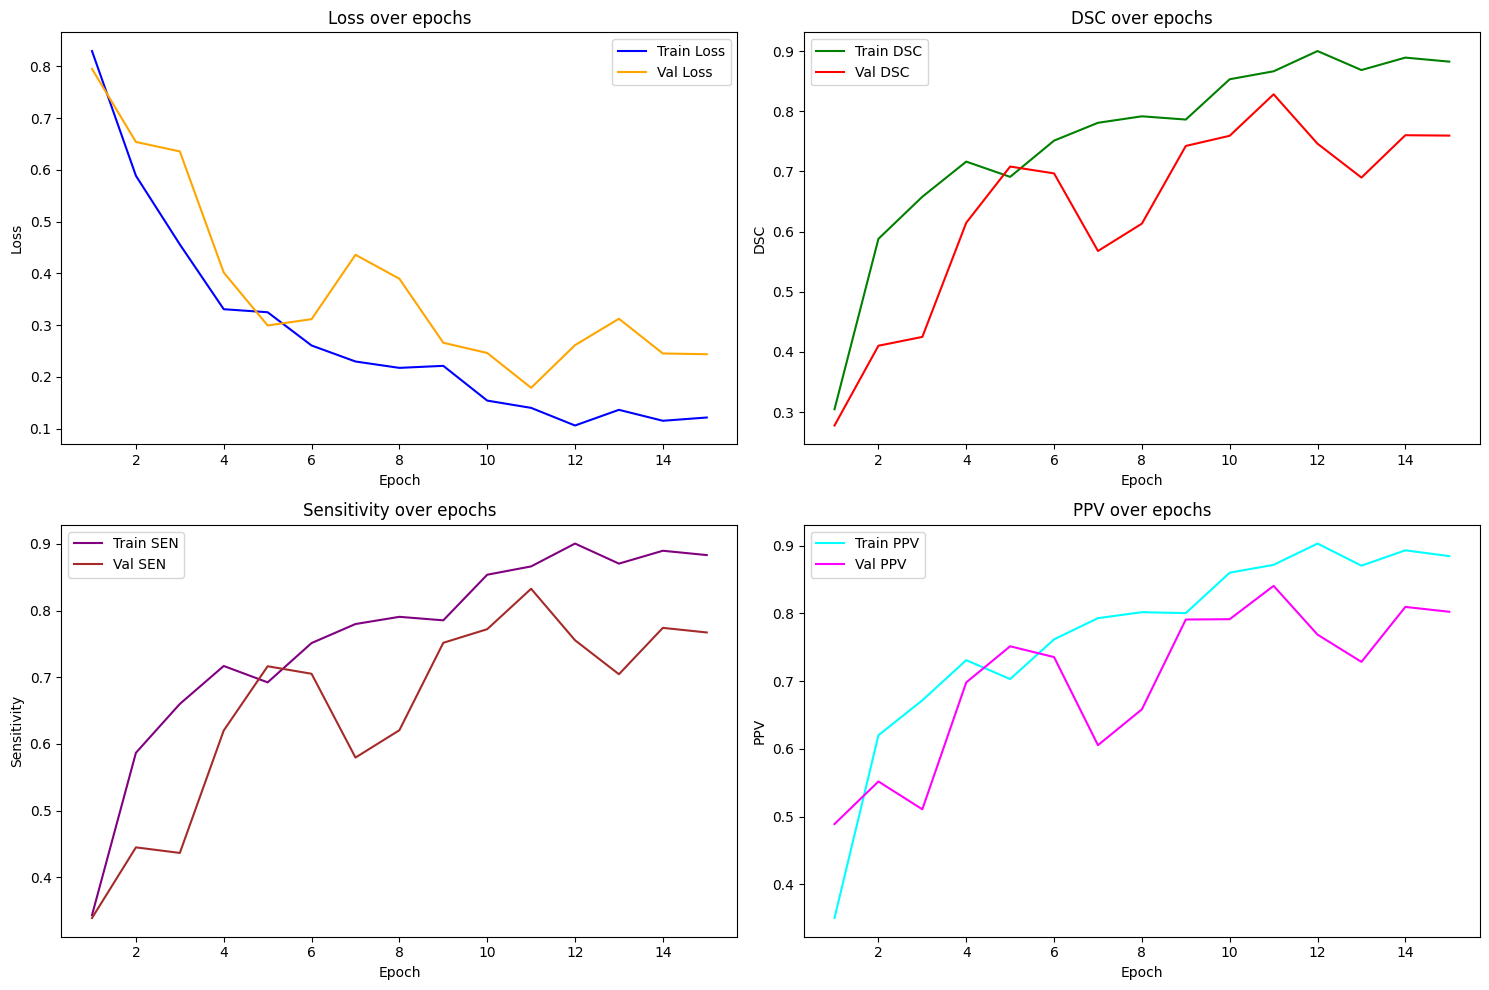

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
file_path = 'models/Mesh_Segmentation_MeshSegNet_15_classes_72samples_metrics.csv'  # Remplacez par le chemin correct
data = pd.read_csv(file_path)

# Extraire les colonnes nécessaires
epochs = data['Epoch']
train_loss = data['Train_Loss']
val_loss = data['Val_Loss']
train_dsc = data['Train_DSC']
val_dsc = data['Val_DSC']
train_sen = data['Train_SEN']
val_sen = data['Val_SEN']
train_ppv = data['Train_PPV']
val_ppv = data['Val_PPV']

# Tracer la courbe de perte (loss) pour l'entraînement et la validation
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Val Loss', color='orange')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer la courbe de DSC (Dice Similarity Coefficient) pour l'entraînement et la validation
plt.subplot(2, 2, 2)
plt.plot(epochs, train_dsc, label='Train DSC', color='green')
plt.plot(epochs, val_dsc, label='Val DSC', color='red')
plt.title('DSC over epochs')
plt.xlabel('Epoch')
plt.ylabel('DSC')
plt.legend()

# Tracer la courbe de SEN (Sensibilité) pour l'entraînement et la validation
plt.subplot(2, 2, 3)
plt.plot(epochs, train_sen, label='Train SEN', color='purple')
plt.plot(epochs, val_sen, label='Val SEN', color='brown')
plt.title('Sensitivity over epochs')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.legend()

# Tracer la courbe de PPV (Précision Positive) pour l'entraînement et la validation
plt.subplot(2, 2, 4)
plt.plot(epochs, train_ppv, label='Train PPV', color='cyan')
plt.plot(epochs, val_ppv, label='Val PPV', color='magenta')
plt.title('PPV over epochs')
plt.xlabel('Epoch')
plt.ylabel('PPV')
plt.legend()

# Ajuster l'espacement et afficher les graphiques
plt.tight_layout()
plt.show()


In [17]:
# Créer une instance de votre modèle
model = MeshSegNet()

# Charger le modèle à partir du fichier .tar
model_path = 'models/Mesh_Segmentation_MeshSegNet_15_classes_72samples_best.tar'
checkpoint = torch.load(model_path)

# Charger les poids du modèle
model.load_state_dict(checkpoint['model_state_dict'])

# Passer en mode évaluation
model.eval()

MeshSegNet(
  (mlp1_conv1): Conv1d(15, 64, kernel_size=(1,), stride=(1,))
  (mlp1_conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (mlp1_bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp1_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fstn): STNkd(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=4096, bias=True)
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [18]:
test_list = 'MeshSegNet/test_list_1.csv'
test_dataset = Mesh_Dataset(data_list_path=test_list, num_classes=num_classes, patch_size=6000)

test_loader = DataLoader(dataset=test_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [19]:
# Vérifier la longueur des datasets

print(f'Test dataset length: {len(test_dataset)}')  # Vérification pour le dataset de test


Test dataset length: 40


In [20]:

test_loss = 0.0
test_dsc = 0.0
test_sen = 0.0
test_ppv = 0.0

with torch.no_grad():  # Pas de calcul de gradients pendant l'évaluation
    for i_batch, batched_test_sample in enumerate(test_loader):
        inputs = batched_test_sample['cells'].to(device, dtype=torch.float)
        labels = batched_test_sample['labels'].to(device, dtype=torch.long)
        A_S = batched_test_sample['A_S'].to(device, dtype=torch.float)
        A_L = batched_test_sample['A_L'].to(device, dtype=torch.float)
        one_hot_labels = nn.functional.one_hot(labels[:, 0, :], num_classes=num_classes)

        outputs = model(inputs, A_S, A_L)

        # Calculer les métriques
        loss = Generalized_Dice_Loss(outputs, one_hot_labels, class_weights)
        dsc = weighting_DSC(outputs, one_hot_labels, class_weights)
        sen = weighting_SEN(outputs, one_hot_labels, class_weights)
        ppv = weighting_PPV(outputs, one_hot_labels, class_weights)

        test_loss += loss.item()
        test_dsc += dsc.item()
        test_sen += sen.item()
        test_ppv += ppv.item()

    # Moyenne des métriques
    test_loss /= len(test_loader)
    test_dsc /= len(test_loader)
    test_sen /= len(test_loader)
    test_ppv /= len(test_loader)

print(f'Test Loss: {test_loss}, DSC: {test_dsc}, SEN: {test_sen}, PPV: {test_ppv}')


Test Loss: 0.3087295934557915, DSC: 0.6907888919115066, SEN: 0.7086933732032776, PPV: 0.7271457225084305


In [30]:
checkpoint = torch.load(os.path.join(previous_check_point_path, previous_check_point_name), map_location='cpu')
print("Checkpoint loaded:", checkpoint)


Checkpoint loaded: {'epoch': 15, 'model_state_dict': OrderedDict({'mlp1_conv1.weight': tensor([[[ 2.5772e-01],
         [ 1.8752e-01],
         [ 7.2530e-02],
         [-2.1707e-01],
         [-2.1180e-01],
         [ 1.8758e-01],
         [ 1.4061e-01],
         [ 9.6912e-02],
         [ 4.6793e-02],
         [ 2.1912e-01],
         [ 7.4228e-02],
         [ 1.2671e-01],
         [ 8.1855e-02],
         [-1.6291e-01],
         [-1.9735e-01]],

        [[-1.3112e-01],
         [ 5.5638e-02],
         [-2.4571e-01],
         [ 1.1996e-02],
         [-2.3503e-02],
         [-1.5818e-01],
         [ 5.4132e-02],
         [ 2.1272e-01],
         [-1.6353e-01],
         [-8.5343e-03],
         [-4.3153e-02],
         [-1.3731e-01],
         [ 2.0133e-01],
         [-2.1541e-01],
         [-6.7790e-02]],

        [[-9.5483e-02],
         [ 8.4244e-02],
         [ 6.4374e-02],
         [ 2.0139e-01],
         [ 9.9937e-02],
         [ 1.9696e-03],
         [-1.3376e-01],
         [-2.4505e-01

In [31]:
print(model)



MeshSegNet(
  (mlp1_conv1): Conv1d(15, 64, kernel_size=(1,), stride=(1,))
  (mlp1_conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (mlp1_bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp1_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fstn): STNkd(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=4096, bias=True)
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [32]:
print("Loss at batch {}: {}".format(i_batch, loss.item()))


Loss at batch 0: 0.7682421803474426


Step 4 test :

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import utils
import vedo
import pandas as pd
from scipy.spatial import distance_matrix

if __name__ == '__main__':

    torch.cuda.set_device(utils.get_avail_gpu())  # assign which gpu will be used (only linux works)

    model_path = 'models'
    model_name = 'Mesh_Segmentation_MeshSegNet_15_classes_72samples_best.tar'

    mesh_path = 'augmentation_vtp_data'  # Set the path to the augmented data

    # Lire le fichier CSV sans spécifier de colonnes, car il n'y en a pas
    test_mesh_filenames = pd.read_csv('MeshSegNet/test_list_1.csv', header=None)[0].values

    test_path = './test'
    if not os.path.exists(test_path):
        os.mkdir(test_path)

    num_classes = 15
    num_channels = 15

    # Set model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MeshSegNet(num_classes=num_classes, num_channels=num_channels).to(device, dtype=torch.float)

    # Load trained model
    checkpoint = torch.load(os.path.join(model_path, model_name), map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
    model = model.to(device, dtype=torch.float)

    # cudnn
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # Testing
    print('Testing')
    model.eval()
    with torch.no_grad():
        for test_mesh_file in test_mesh_filenames:

            print('Predicting Sample filename: {}'.format(test_mesh_file))
            # Read the mesh
            mesh = vedo.load(test_mesh_file)

            if mesh is None:
                print(f"Warning: Could not load mesh for file {test_mesh_file}. Skipping...")
                continue

            # Move mesh to origin
            points = mesh.points()
            mean_cell_centers = mesh.center_of_mass()
            points[:, 0:3] -= mean_cell_centers[0:3]

            ids = np.array(mesh.faces())
            cells = points[ids].reshape(mesh.ncells, 9).astype(dtype='float32')

            # Calculate normals
            mesh.compute_normals()
            normals = mesh.celldata['Normals']

            # **Correcting the barycenters computation**
            # Retrieve cell centers without treating them as a callable
            barycenters = mesh.cell_centers  # no parentheses, since this returns an array
            barycenters -= mean_cell_centers[0:3]  # Move to origin

            # Normalize data
            maxs = points.max(axis=0)
            mins = points.min(axis=0)
            means = points.mean(axis=0)
            stds = points.std(axis=0)
            nmeans = normals.mean(axis=0)
            nstds = normals.std(axis=0)

            for i in range(3):
                cells[:, i] = (cells[:, i] - means[i]) / stds[i]  # point 1
                cells[:, i + 3] = (cells[:, i + 3] - means[i]) / stds[i]  # point 2
                cells[:, i + 6] = (cells[:, i + 6] - means[i]) / stds[i]  # point 3
                barycenters[:, i] = (barycenters[:, i] - mins[i]) / (maxs[i] - mins[i])
                normals[:, i] = (normals[:, i] - nmeans[i]) / nstds[i]

            X = np.column_stack((cells, barycenters, normals))

            # Computing A_S and A_L
            A_S = np.zeros([X.shape[0], X.shape[0]], dtype='float32')
            A_L = np.zeros([X.shape[0], X.shape[0]], dtype='float32')
            D = distance_matrix(X[:, 9:12], X[:, 9:12])
            A_S[D < 0.1] = 1.0
            A_S = A_S / np.dot(np.sum(A_S, axis=1, keepdims=True), np.ones((1, X.shape[0])))

            A_L[D < 0.2] = 1.0
            A_L = A_L / np.dot(np.sum(A_L, axis=1, keepdims=True), np.ones((1, X.shape[0])))

            # Numpy -> torch.tensor
            X = X.transpose(1, 0)
            X = X.reshape([1, X.shape[0], X.shape[1]])
            X = torch.from_numpy(X).to(device, dtype=torch.float)
            A_S = A_S.reshape([1, A_S.shape[0], A_S.shape[1]])
            A_L = A_L.reshape([1, A_L.shape[0], A_L.shape[1]])
            A_S = torch.from_numpy(A_S).to(device, dtype=torch.float)
            A_L = torch.from_numpy(A_L).to(device, dtype=torch.float)

            tensor_prob_output = model(X, A_S, A_L).to(device, dtype=torch.float)
            patch_prob_output = tensor_prob_output.cpu().numpy()

            predicted_labels = np.argmax(patch_prob_output[0, :], axis=-1)

            # Output predicted labels
            mesh2 = mesh.clone()
            mesh2.celldata['MaterialIds'] = predicted_labels
            vedo.write(mesh2, os.path.join(test_path, 'Sample_{}_predicted.vtp'.format(os.path.basename(test_mesh_file))), binary=True)

    print("Testing completed. Segmented meshes have been saved.")


No GPU available, returning CPU.


C:\Users\HP\AppData\Local\Temp\ipykernel_11160\3162619739.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(model_path, model_name), 

AttributeError: module 'torch' has no attribute '_utils'

In [60]:
import vedo
from vedo import Plotter, load
import os
from PIL import Image

# Charger le premier fichier .vtp
mesh_path = "test/Sample_Sample_2_Aug3.vtp_predicted.vtp"

# Vérifier si le fichier existe
if not os.path.exists(mesh_path):
    print(f"File not found: {mesh_path}")
else:
    try:
        # Charger le fichier .vtp
        mesh = load(mesh_path)

        # Vérifier si le maillage est correctement chargé
        if mesh is None:
            print("Failed to load mesh.")
        else:
            print("Mesh loaded successfully.")

            # Créer un plotter
            plotter = Plotter(offscreen=True)

            # Afficher le maillage
            plotter.show(mesh, axes=1)

            # Sauvegarder l'image dans un fichier
            plotter.screenshot('mesh_image.png')

            # Afficher l'image
            img = Image.open('mesh_image.png')
            img.show()

    except Exception as e:
        print(f"An error occurred: {e}")


Mesh loaded successfully.


Step 5 :

In [21]:
import os
import numpy as np
import torch
import torch.nn as nn

import vedo
import pandas as pd

from scipy.spatial import distance_matrix
import utils

if __name__ == '__main__':

    model_path = 'models'
    model_name = 'Mesh_Segmentation_MeshSegNet_15_classes_72samples_best.tar'

    mesh_path = 'test'  # need to define
    sample_filenames = ['4.obj'] # need to define
    output_path = 'outputs'
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    num_classes = 15
    num_channels = 15

    # set model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MeshSegNet(num_classes=num_classes, num_channels=num_channels).to(device, dtype=torch.float)

    # load trained model
    checkpoint = torch.load(os.path.join(model_path, model_name), map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
    model = model.to(device, dtype=torch.float)

    #cudnn
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # Predicting
    model.eval()
    with torch.no_grad():
        for i_sample in sample_filenames:

            print('Predicting Sample filename: {}'.format(i_sample))
            mesh = vedo.load(os.path.join(mesh_path, i_sample))

            # pre-processing: downsampling
            if mesh.ncells > 10000:
                print('\tDownsampling...')
                target_num = 10000
                ratio = target_num/mesh.ncells # calculate ratio
                mesh_d = mesh.clone()
                mesh_d.decimate(fraction=ratio)
                predicted_labels_d = np.zeros([mesh_d.ncells, 1], dtype=np.int32)
            else:
                mesh_d = mesh.clone()
                predicted_labels_d = np.zeros([mesh_d.ncells, 1], dtype=np.int32)

            # move mesh to origin
            print('\tPredicting...')
            points = mesh_d.points()
            mean_cell_centers = mesh_d.center_of_mass()
            points[:, 0:3] -= mean_cell_centers[0:3]

            ids = np.array(mesh_d.faces())
            cells = points[ids].reshape(mesh_d.ncells, 9).astype(dtype='float32')

            # customized normal calculation; the vtk/vedo build-in function will change number of points
            mesh_d.compute_normals()
            normals = mesh_d.celldata['Normals']

            # move mesh to origin
            barycenters = mesh_d.cell_centers() # don't need to copy
            barycenters -= mean_cell_centers[0:3]

            #normalized data
            maxs = points.max(axis=0)
            mins = points.min(axis=0)
            means = points.mean(axis=0)
            stds = points.std(axis=0)
            nmeans = normals.mean(axis=0)
            nstds = normals.std(axis=0)

            for i in range(3):
                cells[:, i] = (cells[:, i] - means[i]) / stds[i] #point 1
                cells[:, i+3] = (cells[:, i+3] - means[i]) / stds[i] #point 2
                cells[:, i+6] = (cells[:, i+6] - means[i]) / stds[i] #point 3
                barycenters[:,i] = (barycenters[:,i] - mins[i]) / (maxs[i]-mins[i])
                normals[:,i] = (normals[:,i] - nmeans[i]) / nstds[i]

            X = np.column_stack((cells, barycenters, normals))

            # computing A_S and A_L
            A_S = np.zeros([X.shape[0], X.shape[0]], dtype='float32')
            A_L = np.zeros([X.shape[0], X.shape[0]], dtype='float32')
            D = distance_matrix(X[:, 9:12], X[:, 9:12])
            A_S[D<0.1] = 1.0
            A_S = A_S / np.dot(np.sum(A_S, axis=1, keepdims=True), np.ones((1, X.shape[0])))

            A_L[D<0.2] = 1.0
            A_L = A_L / np.dot(np.sum(A_L, axis=1, keepdims=True), np.ones((1, X.shape[0])))

            # numpy -> torch.tensor
            X = X.transpose(1, 0)
            X = X.reshape([1, X.shape[0], X.shape[1]])
            X = torch.from_numpy(X).to(device, dtype=torch.float)
            A_S = A_S.reshape([1, A_S.shape[0], A_S.shape[1]])
            A_L = A_L.reshape([1, A_L.shape[0], A_L.shape[1]])
            A_S = torch.from_numpy(A_S).to(device, dtype=torch.float)
            A_L = torch.from_numpy(A_L).to(device, dtype=torch.float)

            tensor_prob_output = model(X, A_S, A_L).to(device, dtype=torch.float)
            patch_prob_output = tensor_prob_output.cpu().numpy()

            for i_label in range(num_classes):
                predicted_labels_d[np.argmax(patch_prob_output[0, :], axis=-1)==i_label] = i_label

            # output downsampled predicted labels
            mesh2 = mesh_d.clone()
            mesh2.celldata['MaterialIds'] = predicted_labels_d
            vedo.write(mesh2, os.path.join(output_path, '{}_d_predicted_step5.vtp'.format(i_sample[:-4])))

            print('Sample filename: {} completed'.format(i_sample))


Predicting Sample filename: 4.obj
	Downsampling...
	Predicting...
         mesh.points() -> mesh.vertices
         (silence this with vedo.core.warnings['points_getter']=False)


TypeError: 'numpy.ndarray' object is not callable